# MNIST CNN klasifikacija

U ovoj svesci bavićemo se, takođe, zadatkom klasifikacije MNIST slika. U pristupu ćemo koristiti konvolutivne neuronske mreže.

Prvo ćemo učitati sve neophodne biblioteke.

In [26]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras import utils
from keras import backend as K

In [27]:
np.random.seed(7)

## Korak 1: Učitavanje skupa podataka

Da bismo učitali podatke, iskoristićemo podršku Keras biblioteke.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Prilikom obrade slika ulazi u mrežu treba da budu 4D tenzori. Uzimaju se u obzir širina i visina slike, broj kanala (jedan za monohromatske ili tri za RGB slike) i broj instacni. Stoga je učitane podatke potrebno transformisati na ovaj oblik. 

<img src='assets/4D_tensor.png'>

Postoje dve konvencije zapisa slika. `Channels last` zapis je oblika `(samples, height, width, color_depth)`, a `chanell first` oblika `(samples, color_depth, height, width)`. Keras biblioteka (i TensorFlow) podrazumevano koriste `Channel last` zapis. Tako se, na primer, paketić veličine 128 koji sadrži crno-bele slike dimenzija 256x256 opisuje tenzorom dimenzija (128, 256, 256, 1), a recimo, paketić veličine 128 slika koje su u RGB modu tenzorom dimenzija (128, 256, 256, 3).

Sledeći kod proverava koje od ovih podešavanja važi. U daljem radu se svakako možemo osloniti na podrazumevana podešavanja.

Dimenzije slike ćemo sačuvati na nivou `img_rows` i `img_cols` promenljivih.

In [4]:
img_rows = 28
img_cols = 28

In [5]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Korak 2: Priprema podataka

Slike ćemo pripremiti tako što ćemo ih normalizovati, tj. svesti vrednosti pojedinačnih piksela na vrednost iz intervala iz [0, 1]. Prethodno ćemo promeniti tip elemenata matrice sa uint8 na float32 kako bi mogli da sačuvamo realne vrednosti.

In [6]:
X_train = X_train.astype('float32')
X_train /= 255

In [7]:
X_test = X_test.astype('float32')
X_test /= 255

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

Vrednosti ciljne promenljive ćemo pripremiti tako što ćemo ih transformisati u vektore dužine 10 sa jedinicom na poziciji koja odgovara vrednosti cifre (takozvano *one-hot* kodiranje). Na primer, broj 3 će biti transformisan u vektor \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\] sa jedinicom na poziciji tri. 

Za ovu transformaciju iskoristićemo funkciju `to_categorical` paketa `keras.utils`.

In [10]:
number_of_classes = 10

y_train = utils.to_categorical(y_train, number_of_classes)
y_test = utils.to_categorical(y_test, number_of_classes)

## Korak 3: Pravljenje modela

Naš model će se sastojati iz više konvolutivnih i agregacionih slojeva. 

Konvolutivni slojevi `Conv2D` se konfigurišu tako što se prvo navede broj filtera (parametar `filters`, obično neimenovan), zatim veličine kernela (`kernel_size` parametar), veličina pomeraja (parametar `strides`) i uokvirenje (`padding` parametar). <img src='assets/convolution_operation.gif' style='height: 300px'>

Na primer, na slici je prikazan kernel veličine 3x3 koji prolazi kroz ulaz sa horizontalnim i vertikalnim pomerajem veličine 2. Dodati beli skup kvadrata predstavlja uokvirenje i u zavisnosti od njegovog prisustva veličina izlazne slike može biti istih dimenzija (u Keras biblioteci se ovo naglašava vrednošću same) ili nešto manja (u Keras biblioteci se ovo naglašava vrednošću valid). 

Agregacioni slojevi (`MaxPooling2D` i `AvgPooling2D`) vrše redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne ili prosečne vrednosti. Veličina bloka zadaje se parametrom `pool_size`. <img src='assets/pooling.png' style='width: 300px'>

Prilikom treniranja koristićemo i `Dropout` tehniku regularizacije. Podsetimo se da na ovaj način isključujemo nasumično odabrane neurone i omogućavamo drugačiji protok podataka kroz mrežu. <img src='assets/dropout.png'>

Funkcija `Flatten` se koristi za transformisanje matrica u vektore i obično se koristi kao priprema za dalji gusti deo mreže. 

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_classes, activation='softmax'))

Prikaz modela i uvid u broj parametara koje mreža treba da nauči možemo da dobijemo pozivom funkcije `summary`.

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

Arhitekturu modela mreže možemo prikazati i u formi usmerenog grafa. Za to će nam trebati biblioteke `pydot` i `graphviz`  koji se mogu instalirati, redom, komandama `conda install -c anaconda pydot` i `conda install -c anaconda graphviz`. Ova dva paketa omogućavaju rad sa `DOT` jezikom koji se koristi za opis grafova. 

In [14]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Funkcija `model_to_dot` se koristi za transformisanje modela u `DOT` zapis koji se zatim funkcijom `create` transformiše u SVG sličicu. Za prikaz SVG slika koristimo `display` funkcionalnost IPython-a.

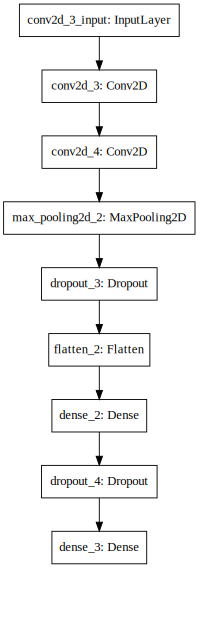

In [16]:
display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))

Funkcija gubitka koju mreža minimizuje će biti `kategorička unakrsna entropija`. Za treniranje mreže ćemo koristiti optimizator `Adam` sa podešenim korakom učenja. 

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Mrežu ćemo trenirati koristeći paketiće veličine 128 u 12 epoha. Treniranje mreže će malo duže trajati.

In [20]:
batch_size = 128
epochs = 12

In [22]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 183s 4ms/step - loss: 0.2679 - accuracy: 0.9181 - val_loss: 0.0644 - val_accuracy: 0.9823
Epoch 2/12
48000/48000 [==============================] - 183s 4ms/step - loss: 0.0930 - accuracy: 0.9723 - val_loss: 0.0495 - val_accuracy: 0.9850
Epoch 3/12
48000/48000 [==============================] - 194s 4ms/step - loss: 0.0695 - accuracy: 0.9791 - val_loss: 0.0437 - val_accuracy: 0.9860
Epoch 4/12
48000/48000 [==============================] - 193s 4ms/step - loss: 0.0577 - accuracy: 0.9822 - val_loss: 0.0382 - val_accuracy: 0.9886
Epoch 5/12
48000/48000 [==============================] - 198s 4ms/step - loss: 0.0498 - accuracy: 0.9845 - val_loss: 0.0371 - val_accuracy: 0.9898
Epoch 6/12
48000/48000 [==============================] - 186s 4ms/step - loss: 0.0417 - accuracy: 0.9871 - val_loss: 0.0362 - val_accuracy: 0.9896
Epoch 7/12
480

Možemo i nacrtati grafike funkcije gubitka i tačnosti u toku treniranja.

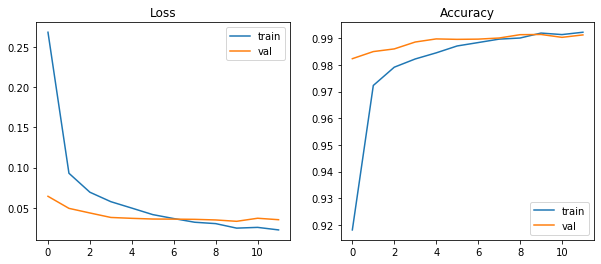

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

Na osnovu ovih grafika možemo primetiti da smo sa učenjem mogli završiti nešto ranije, na primer, već oko sedme epohe.

## Korak 4: Analiza i evaluacija modela

Mrežu ćemo evaluirati na test skupu. 

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028786243012373324
Test accuracy: 0.9915000200271606


Ispisaćemo još matricu konfuzije našeg klasifikatora.

In [32]:
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

In [33]:
y_predicted_classes.shape

(10000,)

In [37]:
y_test_classes = np.argmax(y_test, axis = 1) 

In [39]:
y_test_classes.shape

(10000,)

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)

In [43]:
print(confusion_matrix)

[[ 977    0    0    1    0    0    1    0    1    0]
 [   0 1130    1    1    0    0    0    2    1    0]
 [   2    0 1024    0    0    0    0    6    0    0]
 [   0    0    2 1002    0    4    0    1    1    0]
 [   0    0    0    0  975    0    0    0    2    5]
 [   1    0    0    4    0  886    1    0    0    0]
 [   6    2    0    0    2    4  942    0    2    0]
 [   0    1    5    0    0    0    0 1019    1    2]
 [   3    1    0    1    0    0    0    1  963    5]
 [   1    1    0    0    3    3    0    2    2  997]]


In [45]:
report = classification_report(y_test_classes, y_predicted_classes)

In [46]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



Vidimo da je ovaj model, po svojim performansama, bolji od prethodnog model na kojem smo radili.

<div class='alert alert-info'>
    Za dalje istraživanje: 
    <a href='https://cs231n.github.io/convolutional-networks/'> CNN for visual recognition </a>
</div>